# Analyze models using pcFVA
## Setup
### Import packages

In [1]:
import textwrap
import warnings
from collections import defaultdict
from pathlib import Path

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
from cobra.flux_analysis.variability import flux_variability_analysis
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rbc_gem_utils import (COBRA_CONFIGURATION, GEM_NAME, build_string,
                           read_cobra_model, show_versions, split_string)
from rbc_gem_utils.analysis.overlay import (DEFAULT_ENZYME_TOTAL_SUFFIX,
                                            ComplexDilution,
                                            add_relaxation_budget,
                                            load_overlay_model)
from rbc_gem_utils.visualization import cmap_map
from scipy.stats import spearmanr

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Arial"

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip 

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
data_path = Path("data").resolve()
models_path = Path("models").resolve()
figures_path = Path("figures").resolve()

dataset_name = "RBComics"
dataset_path = Path(dataset_name).resolve()
dataset_models_dirpath = Path(f"{dataset_path}/pcmodels")
pcfva_results_dirpath = Path(f"{dataset_path}/pcFVA")
version = "1.2.0"

# Make sure to unzip the models first if you are going to simulate!
sample_prefix, time_prefix = ("S", "D")
# Integers are easier to work with for time points
timepoints = [10, 23, 42]

imagetype = "png"
transparent = True
save_figures = True
overwrite = True

ftype = "xml"
model = read_cobra_model(f"{models_path}/{GEM_NAME.replace('-', '_')}.{ftype}")
pcmodel = load_overlay_model(filename=f"{models_path}/{model.id}_PC.{ftype}")

# For this workflow, shut off complex dilution reactions at the start
for cplx_dilution in pcmodel.reactions.query(lambda x: isinstance(x, ComplexDilution)):
    cplx_dilution.bounds = (0, 0)

add_relaxation_budget(pcmodel, 0, verbose=False)
pcmodel

Name,RBC_GEM_PC
Memory address,15100a7d0
Number of metabolites,10411
Number of reactions,19620
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Generate list of PC-models to load and simulate

In [4]:
def get_sample_from_id(model_id, sample_prefix=""):
    sample = model_id.rsplit("_", 2)[-2]
    try:
        return int(sample.replace(sample_prefix, ""))
    except ValueError:
        return sample


def get_time_from_id(model_id, time_prefix=""):
    time = model_id.rsplit("_", 2)[-1]
    try:
        return int(time.replace(time_prefix, ""))
    except ValueError:
        return time

In [5]:
model_names = set(
    [
        fp.parts[-1].replace(fp.suffix, "")
        for fp in list(dataset_models_dirpath.iterdir())
        if fp.parts[-1].startswith(pcmodel.id)
    ]
)
sample_model_ids = sorted(
    [
        x
        for x in model_names
        if isinstance(get_sample_from_id(x, sample_prefix), (int, float))
    ],
    key=lambda x: (
        get_sample_from_id(x, sample_prefix),
        get_time_from_id(x, time_prefix),
    ),
)
operation_model_ids = sorted(
    [
        x
        for x in model_names
        if not isinstance(get_sample_from_id(x, sample_prefix), (int, float))
    ],
    key=lambda x: (
        get_sample_from_id(x, sample_prefix),
        get_time_from_id(x, time_prefix),
    ),
)
operations = set([get_sample_from_id(x, sample_prefix) for x in operation_model_ids])
model_names = operation_model_ids + sample_model_ids
list_of_pcmodels = model_names.copy()
list_of_pcmodels

['RBC_GEM_PC_Mean_D10',
 'RBC_GEM_PC_Mean_D23',
 'RBC_GEM_PC_Mean_D42',
 'RBC_GEM_PC_Median_D10',
 'RBC_GEM_PC_Median_D23',
 'RBC_GEM_PC_Median_D42',
 'RBC_GEM_PC_S1_D10',
 'RBC_GEM_PC_S1_D23',
 'RBC_GEM_PC_S1_D42',
 'RBC_GEM_PC_S2_D10',
 'RBC_GEM_PC_S2_D23',
 'RBC_GEM_PC_S2_D42',
 'RBC_GEM_PC_S3_D10',
 'RBC_GEM_PC_S3_D23',
 'RBC_GEM_PC_S3_D42',
 'RBC_GEM_PC_S4_D10',
 'RBC_GEM_PC_S4_D23',
 'RBC_GEM_PC_S4_D42',
 'RBC_GEM_PC_S5_D10',
 'RBC_GEM_PC_S5_D23',
 'RBC_GEM_PC_S5_D42',
 'RBC_GEM_PC_S6_D10',
 'RBC_GEM_PC_S6_D23',
 'RBC_GEM_PC_S6_D42',
 'RBC_GEM_PC_S7_D10',
 'RBC_GEM_PC_S7_D23',
 'RBC_GEM_PC_S7_D42',
 'RBC_GEM_PC_S8_D10',
 'RBC_GEM_PC_S8_D23',
 'RBC_GEM_PC_S8_D42',
 'RBC_GEM_PC_S9_D10',
 'RBC_GEM_PC_S9_D23',
 'RBC_GEM_PC_S9_D42',
 'RBC_GEM_PC_S10_D10',
 'RBC_GEM_PC_S10_D23',
 'RBC_GEM_PC_S10_D42',
 'RBC_GEM_PC_S11_D10',
 'RBC_GEM_PC_S11_D23',
 'RBC_GEM_PC_S11_D42',
 'RBC_GEM_PC_S12_D10',
 'RBC_GEM_PC_S12_D23',
 'RBC_GEM_PC_S12_D42',
 'RBC_GEM_PC_S13_D10',
 'RBC_GEM_PC_S13_D23',
 'R

### Generate results using pcFVA for context specific models
Note that this can take a signficiant amount of time depending on the number of models and their sizes. Best to use a targeted approach in generating results. 
Alternatively, skip result generation and load the previously generated results.

In [6]:
verbose = True
ftype = "xml"  # In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
use_only_necessary_reactions = True
optimum_percents = [0.00, 0.50, 0.90, 0.99]
enzyme_total_suffix = DEFAULT_ENZYME_TOTAL_SUFFIX
# Reactions in addition to the minimum for flux-abundance correlations
list_of_reactions = []
# # Use to get ALL reactions in the original model
# list_of_reactions += model.reactions.list_attr("id")
# # Use to get ALL reactions in the PC model
# list_of_reactions += pcmodel.reactions.list_attr("id")

#### Generate results for subset of PC model reactions
##### Reactions necessary for all flux-abundance correlation computations.
To reduce computation time, a subset of reactions can be defined. 
For flux-abundance correlations, the minimum reaction set are reactions associated with genes associated and the corresponding enzyme dilution reaction for total enzyme.

In [7]:
min_reaction_list = model.reactions.query(lambda x: x.gene_reaction_rule).list_attr(
    "id"
)
enzymes_list = pcmodel.reactions.query(
    lambda x: x.id.startswith(f"ENZDL_enzyme_") and enzyme_total_suffix in x.id
).list_attr("id")
relaxation_list = pcmodel.reactions.query(
    lambda x: x.id.startswith(f"RELAX_")
).list_attr("id")
budget_list = pcmodel.reactions.query(lambda x: x.id.startswith(f"PBDL_")).list_attr(
    "id"
)

reaction_enzymes_map = {
    rid: tuple(
        pcmodel.reactions.query(
            lambda x: x.id.startswith(f"ENZDL_enzyme_{rid}_")
        ).list_attr("id")
    )
    for rid in min_reaction_list
}
enzyme_reaction_map = {
    enzyme: rid for rid, enzymes in reaction_enzymes_map.items() for enzyme in enzymes
}
if not enzymes_list:
    enzymes_list = [
        enzyme
        for enzyme, rid in enzyme_reaction_map.items()
        if rid in min_reaction_list
    ]
min_reaction_list += enzymes_list + relaxation_list
print(
    f"Number of reactions minimize/maximize (minimum): {len(min_reaction_list)} / {len(pcmodel.reactions)}"
)

Number of reactions minimize/maximize (minimum): 5191 / 19620


##### Refined set of PC model reactions

In [8]:
if use_only_necessary_reactions:
    reaction_list = min_reaction_list.copy()
else:
    list_of_reactions = [getattr(rid, "_id", rid) for rid in list_of_reactions]
    # No summation variables, only enzyme pairs
    reaction_list = sorted(
        [
            x if isinstance(x, str) else x.id
            for x in set(min_reaction_list).union(list_of_reactions)
        ]
    )
print(
    f"Number of reactions minimize/maximize (chosen):: {len(reaction_list)} / {len(pcmodel.reactions)}"
)

Number of reactions minimize/maximize (chosen):: 5191 / 19620


## Run pcFVA

In [9]:
run_computations = False  # Keep off to use previously computed results

pcfva_solutions = {}
index_cols = ["reactions", "optimum", "model"]
if run_computations:
    for idx, pcmodel_sample in enumerate(list_of_pcmodels, start=1):
        filepath = Path(f"{pcfva_results_dirpath}/{pcmodel_sample}_FVAresults.tsv")
        if filepath.exists():
            if verbose:
                print(
                    f"{idx}) Already finished {pcmodel_sample}, will load results after finishing remaining models."
                )
            continue

        print("================================================")
        print(f"Computing pcFVA results for {pcmodel_sample}")
        print("================================================")
        if isinstance(pcmodel_sample, str):
            if verbose:
                print(f"Loading {pcmodel_sample}.")
            pcmodel_sample = load_overlay_model(
                f"{dataset_models_dirpath}/{pcmodel_sample}.{ftype}"
            )
        try:
            optimum_solutions = []
            if verbose:
                print(f"Starting simulations for {pcmodel_sample}")
            for optimum_percent in optimum_percents:
                pcfva_sol = flux_variability_analysis(
                    pcmodel_sample,
                    reaction_list=reaction_list,
                    loopless=False,
                    fraction_of_optimum=optimum_percent,
                    processes=COBRA_CONFIGURATION.processes,
                )
                pcfva_sol.index = pd.MultiIndex.from_tuples(
                    [
                        (rid, optimum_percent, pcmodel_sample.id)
                        for rid in pcfva_sol.index
                    ],
                    names=index_cols,
                )
                optimum_solutions.append(pcfva_sol)
                if verbose:
                    print(f"Finished pcFVA for percent optimum: {optimum_percent}.")
            pcfva_sol = pd.concat(optimum_solutions, axis=0)
            pcfva_sol.to_csv(filepath, sep="\t", index=True)
            pcfva_solutions[str(pcmodel_sample)] = pcfva_sol
            if verbose:
                print(f"Finished all simulations for {pcmodel_sample}")
        except Exception as e:
            if verbose:
                print(f"{pcmodel_sample} failed due to an exception.")
            with open(f"{pcfva_results_dirpath}/pcFVA-errors.log", "a") as file:
                file.write(f"{pcmodel_sample} failed due to an exception. {str(e)}\n")

    # Load missing solutions if interuptions required
    for pcmodel_sample in list_of_pcmodels:
        if pcmodel_sample in pcfva_solutions:
            continue
        filepath = Path(f"{pcfva_results_dirpath}/{pcmodel_sample}_FVAresults.tsv")
        if filepath.exists():
            pcfva_solutions[str(pcmodel_sample)] = pd.read_csv(
                filepath, sep="\t", index_col=index_cols
            )
    pcfva_solutions = {
        k: pcfva_solutions[k] for k in list_of_pcmodels if k in pcfva_solutions
    }

if pcfva_solutions:
    df_pcfva_all = pd.concat(list(pcfva_solutions.values()), axis=0)
    # Regroup solutions
    df_pcfva_all = df_pcfva_all.sort_index(level=index_cols).reset_index(drop=False)
    df_pcfva_all.to_csv(
        f"{dataset_path}/{pcmodel.id}_FVAresults_ALL.tsv", sep="\t", index=False
    )
else:
    df_pcfva_all = pd.DataFrame()
df_pcfva_all

""


## Load pcFVA generated results

In [10]:
# Test to see if results were recently generated in this run, otherwise load DataFrame of generated results
try:
    assert not df_pcfva_all.empty
except (NameError, AssertionError):
    df_pcfva_all = pd.read_csv(
        f"{dataset_path}/{pcmodel.id}_{dataset_name}_FVAresults_ALL.tsv",
        sep="\t",
        index_col=None,
    )
    # Filter out results for models not in the desired model list

df_pcfva_all

,reactions,optimum,model,minimum,maximum
0,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D10,0.000000,0.108130
1,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D23,0.000000,0.108141
2,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D42,0.000000,0.108129
3,13DAMPPOX,0.00,RBC_GEM_PC_Median_D10,0.000000,0.108220
4,13DAMPPOX,0.00,RBC_GEM_PC_Median_D23,0.000000,0.108230
...,...,...,...,...,...
145538995,ZN2t,0.99,RBC_GEM_PC_S99_D23,-0.741626,0.741626
145538996,ZN2t,0.99,RBC_GEM_PC_S99_D42,-0.742404,0.742404
145538997,ZN2t,0.99,RBC_GEM_PC_S9_D10,-0.744011,0.744011
145538998,ZN2t,0.99,RBC_GEM_PC_S9_D23,-0.742300,0.742300


#### Export minimum and maximum ranges for dataset specific PC model

In [11]:
df_reaction_ranges = df_pcfva_all.groupby(["reactions"]).agg(
    {
        "minimum": "min",
        "maximum": "max",
    }
)
df_reaction_ranges.to_csv(
    f"{dataset_path}/{pcmodel.id}_{dataset_name}_reaction_bounds.tsv",
    sep="\t",
    index=True,
)
df_reaction_ranges

,minimum,maximum
reactions,,
13DAMPPOX,0.000000,0.108715
15KPGE1Ry,0.000000,0.000000
15KPGE2Ry,0.000000,0.000000
15KPGE3Ry,0.000000,0.000000
15KPGF1Ry,0.000000,0.000000
...,...,...
YYYTPAP,0.000000,0.000000
ZN2Htex2,0.000000,1.901283
ZN2_2HCO3t,0.000000,2.282722


### Parse main results into smaller DataFrames
#### Seperate by reaction variable types

In [12]:
# Initialize entries with prefixes used for seperating DataFrames
dict_of_dataframes_types = {
    "reactions": None,
    "proteins": "PROTDL",
    # "complexes": "CPLXFM",
    # "complex_dilutions": "CPLXDL",
    "enzymes": "ENZDL",
    # "enzyme_formation": "ENZFM",
    "budgets": "PBDL",
    "relaxation": "RELAX",
}
for key, prefix in dict_of_dataframes_types.copy().items():
    if prefix:
        df = df_pcfva_all[
            df_pcfva_all["reactions"].apply(lambda x: x.startswith(prefix))
        ]
    else:
        df = df_pcfva_all[
            df_pcfva_all["reactions"].apply(lambda x: x in model.reactions)
        ]
    dict_of_dataframes_types[key] = df.copy()

dict_of_dataframes_types;

#### Seperate by optimum value

In [13]:
# dict_of_dataframes_opt = {
#     optimum: df_pcfva_all[df_pcfva_all["optimum"] == optimum].copy()
#     for optimum in df_pcfva_all["optimum"].unique()
# }
# print(list(dict_of_dataframes_opt))

#### Seperate by model

In [14]:
# dict_of_dataframes_model = {
#     model_id: df_pcfva_all[df_pcfva_all["model"] == model_id].copy()
#     for model_id in df_pcfva_all["model"].unique()
# }
# print(list(dict_of_dataframes_model))

### Create DataFrame for correlation calculations
#### Get maximum reaction fluxes and associated abundance values

In [15]:
groupby_list = ["model", "reactions"]
always_abundance_independent = [
    r.id for r in model.reactions.query(lambda x: not x.boundary and not x.genes)
]
print(
    f"Number of reactions w/o genes, always abundance independent: {len(always_abundance_independent)}"
)
always_abundance_independent;

Number of reactions w/o genes, always abundance independent: 535


##### Get maximum reaction flux

In [16]:
# Get the maximum value of the reaction flux in each direction, regardless of percent optimum
df = dict_of_dataframes_types["reactions"].copy()
df = df.groupby(groupby_list)[["minimum", "maximum"]].agg(
    {
        "minimum": "min",
        "maximum": "max",
    }
)
df_max_flux_per_model = df.abs().max(axis=1)
df_max_flux_per_model.name = "Flux"
df_max_flux_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  13DAMPPOX          0.108130
                     15KPGE1Ry          0.000000
                     15KPGE2Ry          0.000000
                     15KPGE3Ry          0.000000
                     15KPGF1Ry          0.000000
                                          ...   
RBC_GEM_PC_S9_D42    YYYTPAP            0.000000
                     ZN2Htex2           1.890257
                     ZN2_2HCO3t         2.277031
                     ZN2_HCO3_SELNIt    2.277031
                     ZN2t               0.743016
Name: Flux, Length: 6071850, dtype: float64

##### Get maximum flux range

In [17]:
# Determine flux range
df = dict_of_dataframes_types["reactions"].copy()
df["Range"] = df["maximum"] - df["minimum"]
df_flux_range_per_model = df.groupby(groupby_list)["Range"].max()
df_flux_range_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  13DAMPPOX          0.108130
                     15KPGE1Ry          0.000000
                     15KPGE2Ry          0.000000
                     15KPGE3Ry          0.000000
                     15KPGF1Ry          0.000000
                                          ...   
RBC_GEM_PC_S9_D42    YYYTPAP            0.000000
                     ZN2Htex2           1.890257
                     ZN2_2HCO3t         2.277031
                     ZN2_HCO3_SELNIt    2.277031
                     ZN2t               1.486032
Name: Range, Length: 6071850, dtype: float64

##### Get maximum abundance

In [18]:
# Determine span association with reaction
df = dict_of_dataframes_types["enzymes"].copy()
df["reactions"] = df["reactions"].apply(lambda x: enzyme_reaction_map[x])
df_max_enzyme_per_model = df.groupby(groupby_list)["maximum"].max()
df_max_enzyme_per_model.name = "Abundance"
df_max_enzyme_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  15KPGE1Ry          17.123347
                     15KPGE2Ry          17.123347
                     15KPGE3Ry          17.123347
                     15KPGF1Ry          17.123347
                     15KPGF2Ry          17.123347
                                          ...    
RBC_GEM_PC_S9_D42    YYYTPAP            18.685207
                     ZN2Htex2            8.078022
                     ZN2_2HCO3t          9.730903
                     ZN2_HCO3_SELNIt     9.730903
                     ZN2t                3.175283
Name: Abundance, Length: 4043574, dtype: float64

##### Merge into one DataFrame

In [19]:
df_reaction_flux_abundance = (
    pd.merge(
        df_max_flux_per_model,
        df_flux_range_per_model,
        left_index=True,
        right_index=True,
    )
    .merge(df_max_enzyme_per_model, left_index=True, right_index=True)
    .reset_index(drop=False)
)
df_reaction_flux_abundance

,model,reactions,Flux,Range,Abundance
0,RBC_GEM_PC_Mean_D10,15KPGE1Ry,0.000000,0.000000,17.123347
1,RBC_GEM_PC_Mean_D10,15KPGE2Ry,0.000000,0.000000,17.123347
2,RBC_GEM_PC_Mean_D10,15KPGE3Ry,0.000000,0.000000,17.123347
3,RBC_GEM_PC_Mean_D10,15KPGF1Ry,0.000000,0.000000,17.123347
4,RBC_GEM_PC_Mean_D10,15KPGF2Ry,0.000000,0.000000,17.123347
...,...,...,...,...,...
4043569,RBC_GEM_PC_S9_D42,YYYTPAP,0.000000,0.000000,18.685207
4043570,RBC_GEM_PC_S9_D42,ZN2Htex2,1.890257,1.890257,8.078022
4043571,RBC_GEM_PC_S9_D42,ZN2_2HCO3t,2.277031,2.277031,9.730903
4043572,RBC_GEM_PC_S9_D42,ZN2_HCO3_SELNIt,2.277031,2.277031,9.730903


### Define helper methods

In [20]:
def prepare_correlation_df(df, pvalue_tol):
    df["pvalue"] = df["pvalue"].apply(
        lambda x: -np.log10(x if x >= pvalue_tol else pvalue_tol)
    )
    df = df.sort_values(["pvalue", "rho"], ascending=[False, False])
    return df


def plot_correlations(
    df, ax=None, histx=True, histy=True, colorbar=True, vertical_lines=None, **kwargs
):
    # Define figure if no axes provided.
    scatter_inch = kwargs.get("scatter_inch", 5.0)
    hist_inch = kwargs.get("hist_inch", 1.0)
    hist_pad = kwargs.get("hist_pad", 0.25)
    if ax is None:
        _, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(
                scatter_inch + (hist_inch + hist_pad if histy else 0),
                scatter_inch + (hist_inch + hist_pad if histx else 0),
            ),
        )
    # X-axis is rho, Y-axis is expected as -log10(pvalue) from correlation prep
    xy = {"x": "rho", "y": "pvalue"}
    limits = {
        "x": (kwargs.get("xmin", -1.0), kwargs.get("xmax", 1.0)),
        "y": (kwargs.get("ymin", 0.0), kwargs.get("ymax", df[xy["y"]].max())),
    }
    pads = {
        axis: kwargs.get(f"{axis}pad", (limits[axis][1] - limits[axis][0]) / 2 / 20)
        for axis in list(xy)
    }
    cmap = kwargs.get("cmap", "viridis")
    zorder = kwargs.get("zorder", 2)
    edgecolor = kwargs.get("edgecolor", "black")
    edgewidth = kwargs.get("edgewidth", 0.5)
    scatter = ax.scatter(
        xy["x"],
        xy["y"],
        data=df,
        c=kwargs.get("c", xy["y"]),
        s=kwargs.get("s", 40),
        zorder=zorder,
        edgecolor=edgecolor,
        linewidth=edgewidth,
        cmap=mpl.colormaps.get_cmap(cmap) if isinstance(cmap, str) else cmap,
        norm=mpl.colors.Normalize(
            vmin=limits["y"][0] - pads["y"], vmax=limits["y"][1] + pads["y"]
        ),
    )
    ax.set_xlabel(r"Spearman Correlation $(\rho)$", fontdict={"size": "xx-large"})
    ax.set_ylabel("-log$_{10}$(p-value)", fontdict={"size": "xx-large"})
    ax.set_xlim((limits["x"][0] - pads["x"], limits["x"][1] + pads["x"]))
    ax.set_ylim((limits["y"][0] - pads["y"], limits["y"][1] + pads["y"]))

    major_ticks = {axis: kwargs.get(f"{axis}tick_major") for axis in list(xy)}
    minor_ticks = {
        axis: kwargs.get(
            f"{axis}tick_minor",
            major_ticks[axis] / 2 if major_ticks[axis] is not None else None,
        )
        for axis in list(xy)
    }
    for axis in list(xy):
        if major_ticks[axis] is not None:
            getattr(ax, f"{axis}axis").set_major_locator(
                mpl.ticker.MultipleLocator(major_ticks[axis])
            )
        if minor_ticks[axis] is not None:
            getattr(ax, f"{axis}axis").set_minor_locator(
                mpl.ticker.MultipleLocator(minor_ticks[axis])
            )
        ax.tick_params(axis=axis, labelsize="large")

    if vertical_lines:
        for lineval, (lineprops, textprops) in vertical_lines.items():
            if lineprops:
                ax.vlines(
                    x=lineval,
                    ymin=limits["y"][0] - pads["y"],
                    ymax=limits["y"][1] + pads["y"],
                    **lineprops,
                )
            if textprops:
                ax.text(x=lineval + pads["x"] / 2, transform=ax.transData, **textprops)

    if kwargs.get("grid", False):
        ax.grid(True, **dict(which="both", alpha=0.75))

    if colorbar:
        cax = ax.inset_axes(
            [
                limits["x"][0] - pads["x"],  # lower left corner xpos
                limits["y"][0] - pads["y"],  # lower left corner ypos
                pads["x"],  # width of colorbar
                limits["y"][1]
                + pads["y"]
                + pads[
                    "y"
                ],  # height of colorbar, need extra ypad to make up for lowering ypos
            ],
            transform=ax.transData,
        )
        cbar = ax.get_figure().colorbar(scatter, cax=cax)
        cax.set_ylim((limits["y"][0] - pads["y"], limits["y"][1] + pads["y"]))
        cax.set_xticks([])
        cax.set_yticks([])

    ax_histx = None
    ax_histy = None
    if histx or histy:
        divider = make_axes_locatable(ax)
        # Histogram axes
        ax_histx = (
            divider.append_axes("top", hist_inch, pad=hist_pad, sharex=ax)
            if histx
            else None
        )
        ax_histy = (
            divider.append_axes("right", hist_inch, pad=hist_pad, sharey=ax)
            if histy
            else None
        )

        for axis, ax_hist in zip(list(xy), [ax_histx, ax_histy]):
            if ax_hist is None:
                continue
            binwidth = kwargs.get(
                f"{axis}binwidth",
                (
                    minor_ticks[axis]
                    if minor_ticks[axis] is not None
                    else major_ticks[axis]
                ),
            )
            counts, bins, patches = ax_hist.hist(
                df[xy[axis]],
                bins=np.arange(limits[axis][0], limits[axis][1] + binwidth, binwidth),
                orientation="vertical" if axis == "x" else "horizontal",
                zorder=zorder,
                edgecolor=edgecolor,
                linewidth=edgewidth,
            )
            other = "y" if axis == "x" else "x"
            ax_hist.tick_params(
                axis=axis, **{f"label{'bottom' if axis == 'x' else 'left'}": False}
            )
            ax_hist.tick_params(axis=other, labelsize="large")
            getattr(ax_hist, f"set_{other}label")("Frequency", fontsize="large")

            tick_major_int = kwargs.get(f"hist{axis}_{other}tick_major")
            if tick_major_int is not None:
                getattr(ax_hist, f"{other}axis").set_major_locator(
                    mpl.ticker.MultipleLocator(tick_major_int)
                )
                getattr(ax_hist, f"{other}axis").set_minor_locator(
                    mpl.ticker.MultipleLocator(tick_major_int / 2)
                )
            getattr(ax_hist, f"set_{other}lim")((0, max(counts) * 1.1))
            if kwargs.get("grid", False):
                ax_hist.grid(True, **dict(which="both", alpha=0.75))

            if vertical_lines and (axis == "x" and ax_hist is not None):
                for lineval, (lineprops, _) in vertical_lines.items():
                    if lineprops:
                        ax_hist.vlines(
                            x=lineval, ymin=0.0, ymax=max(counts) * 1.1, **lineprops
                        )

    return ax, ax_histx, ax_histy

### Create subgroups of models 

In [21]:
# Don't include mean/median in correlation calculations
model_groups = {
    "ALL": [
        x
        for x in list_of_pcmodels
        if not any([op.capitalize() in x for op in operations])
    ],
    "OPERATIONS": operation_model_ids,
}
# model_groups.update({
#     f"{time_prefix}{time}": [x for x in model_groups["ALL"] if x.endswith(f"{time_prefix}{time}")]
#     for time in timepoints
# })
list(model_groups)

['ALL', 'OPERATIONS']

### Compute correlations between maximum flux and abundance

In [22]:
spearman_rankings_group_dict = defaultdict(dict)
verbose = False
reaction_list = list(df_reaction_flux_abundance["reactions"].unique())
corr_results_dirpath = Path(f"{dataset_path}/correlations")
corr_results_dirpath.mkdir(exist_ok=True, parents=True)

In [23]:
run_computations = False  # Keep off to use previously computed results

group_name = "ALL"
column_pair = ("Flux", "Abundance")

if group_name in operations or group_name == "OPERATIONS":
    raise Exception("Cannot use models created using data from statistical operations.")

group_model_list = model_groups[group_name]


filepath = Path(f"{corr_results_dirpath}/{column_pair[0]}_{column_pair[1]}.tsv")
if filepath.exists() and not run_computations:
    print(
        "Already computed correlations between '{}' and '{}' for '{}' models".format(
            *column_pair, group_name
        )
    )
    df_correlations = pd.read_csv(f"{filepath}", sep="\t", index_col=0)
    df_correlations = df_correlations.loc[reaction_list]
elif run_computations:
    print("=========================================================================")
    print(
        "Computing correlations between '{}' and '{}' for '{}' models".format(
            *column_pair, group_name
        )
    )
    print("=========================================================================")
    correlations_dict = defaultdict(dict)
    model_list = group_model_list.copy()
    for rid in reaction_list:
        df = df_reaction_flux_abundance[df_reaction_flux_abundance["reactions"] == rid]
        df = df.drop("reactions", axis=1)
        df = df.set_index("model")
        # Expected warnings emitted are due to constant input array, in which the correlation coefficient is not defined. Corresponds to the nan values.
        with warnings.catch_warnings(action="ignore"):
            rho, pvalue = spearmanr(df.loc[model_list, list(column_pair)])
        correlations_dict[rid]["rho"] = rho
        correlations_dict[rid]["pvalue"] = pvalue
        if verbose:
            print(f"For reaction {rid}: rho={rho}, p={pvalue}")
    df_correlations = pd.DataFrame.from_dict(correlations_dict, orient="index")
    df_correlations.to_csv(f"{filepath}", sep="\t", index=True)
else:
    df_correlations = pd.DataFrame()

spearman_rankings_group_dict[group_name][column_pair] = df_correlations
spearman_rankings_group_dict[group_name][column_pair]

Already computed correlations between 'Flux' and 'Abundance' for 'ALL' models


,rho,pvalue
15KPGE1Ry,NaN,NaN
15KPGE2Ry,NaN,NaN
15KPGE3Ry,NaN,NaN
15KPGF1Ry,NaN,NaN
15KPGF2Ry,NaN,NaN
...,...,...
YYYTPAP,NaN,NaN
ZN2Htex2,1.0,0.0
ZN2_2HCO3t,1.0,0.0
ZN2_HCO3_SELNIt,1.0,0.0


#### Visualize correlation results
##### Set common visualization options

In [24]:
# Consistent plot dimensions and values
pvalue_tol = 1e-320
scatter_inch = 5  # Length x width of scatter plot
hist_inch = 1  # Length or width of histogram addition
hist_pad = 0.4  # Space between scatter and histogram
cmap = "viridis"
edgecolor = "black"
edgewidth = 0.5
grid = False
zorder = 2
histx = True
histy = True

##### Visualize

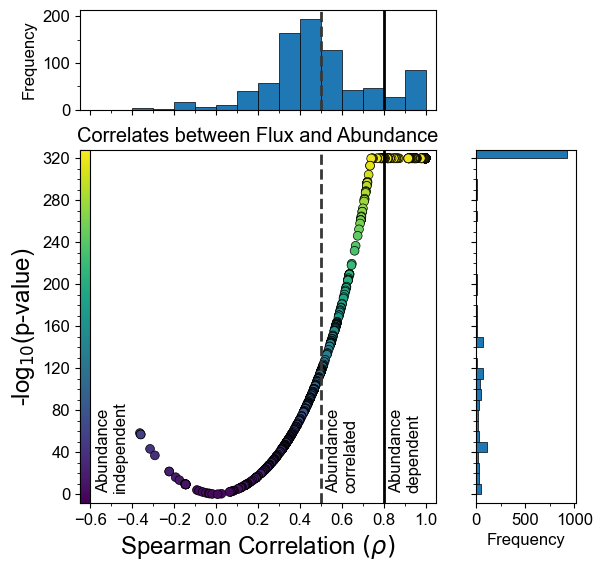

In [25]:
group_name = "ALL"  # Use models in visualizations
column_pair = ("Flux", "Abundance")
xmin, xmax = (-0.60, 1.00)
xpad = 0.05

plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=100,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=40,
    ytick_minor=10,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=500,  # Major x-tick interval for histogram aligned with y-axis
)


df_corr = spearman_rankings_group_dict[group_name][column_pair].copy()
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)

# For abundance lines
abundance_dep_rho_lb = 0.8
abundance_cor_rho_lb = 0.5
ypos = 4
ww = 11
rotation = 90
fontsize = "large"
linewidth = 2
vertical_lines = {
    abundance_dep_rho_lb: (
        dict(color="black", linestyle="-", linewidth=linewidth),
        dict(
            y=ypos,
            s="\n".join(textwrap.wrap("Abundance dependent", width=ww)),
            rotation=rotation,
            fontsize=fontsize,
        ),
    ),
    abundance_cor_rho_lb: (
        dict(color="xkcd:dark grey", linestyle="--", linewidth=linewidth),
        dict(
            y=ypos,
            s="\n".join(textwrap.wrap("Abundance correlated", width=ww)),
            rotation=rotation,
            fontsize=fontsize,
        ),
    ),
    xmin: (
        dict(),
        dict(
            y=ypos,
            s="\n".join(textwrap.wrap("Abundance independent", width=ww)),
            rotation=rotation,
            fontsize=fontsize,
        ),
    ),
}


nrows, ncols = (1, 1)
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
)
ax_scatter, ax_histx, ax_histy = plot_correlations(
    df_corr,
    ax=ax,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines=vertical_lines,
    **plot_kwargs,
)
ax_scatter.set_title(
    f"Correlates between Flux and Abundance",
    fontsize="x-large",
)
if save_figures:
    fig.savefig(
        f"{figures_path}/Fig5_PanelG_FluxAbunCorrelates.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

### Enrich results with subsystems

In [26]:
df_pathways = pd.read_csv(
    f"{data_path}/subsystems.tsv", sep="\t", index_col=0, dtype=str
)
cat_cols = ["subsystem", "category"]
df_pathways = df_pathways.fillna("").reset_index()

# Categories that should be excluded from the figure
categories_to_exclude = {"Pseudoreactions", "Model total"}
# Main categories in figure and abbreviations, all unmapped categories are mapped to "Other"
categories_to_keep = {
    "Amino acid metabolism": mpl.cm.spring,
    "Carbohydrate metabolism": mpl.cm.Greens,
    "Lipid metabolism": mpl.cm.Blues,
    "Metabolism of cofactors and vitamins": mpl.cm.summer,
    "Nucleotide metabolism": mpl.cm.winter,
    "Reactive species": mpl.cm.Reds,
    "Transport reactions": mpl.cm.Purples,
    "Other": mpl.cm.gray_r,
}
use_abbrevs = True
abbrevs = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
barsize = 0.8
cmax = 0.8
cmin = 0.15


colormaps_normal = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x * 1, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)
category_colors = {key: tuple(value(cmax)) for key, value in categories_to_keep.items()}

# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)
df_pathways = df_pathways.rename({"name": "subsystem"}, axis=1)
df_pathways["category"] = df_pathways["category"].apply(
    lambda category: (
        "Other"
        if (
            category not in categories_to_keep and category not in categories_to_exclude
        )
        else category
    )
)
mapping_dict = df_pathways[cat_cols].set_index("subsystem").squeeze().to_dict()

df_pathways

,subsystem,category,kegg.pathway.name,kegg.pathway,notes
0,"Alanine, aspartate and glutamate metabolism",Amino acid metabolism,"Alanine, aspartate and glutamate metabolism",hsa00250,
1,Arginine and proline metabolism,Amino acid metabolism,Arginine and proline metabolism,hsa00330,
2,Cysteine and methionine metabolism,Amino acid metabolism,Cysteine and methionine metabolism,hsa00270,
3,"Glycine, serine and threonine metabolism",Amino acid metabolism,"Glycine, serine and threonine metabolism",hsa00260,
4,Histidine metabolism,Amino acid metabolism,Histidine metabolism,hsa00340,
...,...,...,...,...,...
73,Aminoacyl-tRNA biosynthesis,Other,Aminoacyl-tRNA biosynthesis,has00970,
74,"Transport, extracellular",Transport reactions,,,Representative subsystem for all transport rea...
75,5-fluorouracil metabolism,Other,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."
76,Azathioprine and 6-mercaptopurine metabolism,Other,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."


In [27]:
group_name = "ALL"
column_pair = ("Flux", "Abundance")
df_correlations_flux_abundance = spearman_rankings_group_dict[group_name][
    column_pair
].copy()
gene_map = {
    r: build_string(sorted([g.id for g in pcmodel.reactions.get_by_id(r).genes]))
    for r in df_correlations_flux_abundance.index
}
df_correlations_flux_abundance.index = pd.MultiIndex.from_tuples(
    [(r, gene_map[r]) for r in df_correlations_flux_abundance.index],
    names=("reaction", "genes"),
)
df_correlations_flux_abundance = df_correlations_flux_abundance.reset_index(drop=False)
df_correlations_flux_abundance = df_correlations_flux_abundance.sort_values(
    ["pvalue", "rho", "genes", "reaction"], ascending=[True, False, True, True]
)
df_correlations_flux_abundance = df_correlations_flux_abundance.reset_index(drop=True)
df_correlations_flux_abundance["subsystem"] = df_correlations_flux_abundance[
    "reaction"
].apply(lambda x: model.reactions.get_by_id(x).subsystem)
df_correlations_flux_abundance = df_correlations_flux_abundance.merge(
    df_pathways[["subsystem", "category"]],
    left_on="subsystem",
    right_on="subsystem",
)
df_correlations_flux_abundance.to_csv(
    f"{dataset_path}/{pcmodel.id}_{dataset_name}_FLUXABUN_CORRELATIONS.tsv",
    sep="\t",
    index=False,
)

df_blocked_w_abun = df_correlations_flux_abundance[
    df_correlations_flux_abundance[["rho", "pvalue"]].isna().all(axis=1)
]
df_abun_dep = df_correlations_flux_abundance.loc[
    df_correlations_flux_abundance[
        df_correlations_flux_abundance["rho"] >= abundance_dep_rho_lb
    ].index
]
df_abun_cor = df_correlations_flux_abundance.loc[
    df_correlations_flux_abundance[
        df_correlations_flux_abundance["rho"] < abundance_dep_rho_lb
    ].index
]
df_abun_cor = df_abun_cor.loc[
    df_abun_cor[df_abun_cor["rho"] >= abundance_cor_rho_lb].index
]
df_abun_ind = df_correlations_flux_abundance.loc[
    df_correlations_flux_abundance[
        df_correlations_flux_abundance["rho"] < abundance_cor_rho_lb
    ].index
]


print(
    f"Number of abundance dependent reactions\t({abundance_dep_rho_lb} <= rho      ): {len(df_abun_dep)}"
)
print(
    f"Number of abundance correlated reactions\t({abundance_cor_rho_lb} <= rho < {abundance_dep_rho_lb}): {len(df_abun_cor)}"
)
print(
    f"Number of abundance independent reactions\t(       rho < {abundance_cor_rho_lb}): {len(df_abun_ind)}"
)
print(
    f"Number of blocked reactions with associated abundance:\t{len(df_blocked_w_abun)}"
)
print(
    f"Number of spontaneous reactions (no gene association):\t{len(always_abundance_independent)}"
)
df_correlations_flux_abundance

Number of abundance dependent reactions	(0.8 <= rho      ): 902
Number of abundance correlated reactions	(0.5 <= rho < 0.8): 215
Number of abundance independent reactions	(       rho < 0.5): 497
Number of blocked reactions with associated abundance:	567
Number of spontaneous reactions (no gene association):	535


,reaction,genes,rho,pvalue,subsystem,category
0,PSFLOPt,ABCA1;ABCA7,1.0,0.0,"Transport, extracellular",Transport reactions
1,PCFLOPt,ABCA1;ABCA7;ABCB1;ABCB4,1.0,0.0,"Transport, extracellular",Transport reactions
2,SMFLOPt,ABCA1;ABCA7;ABCB1;ABCB4,1.0,0.0,"Transport, extracellular",Transport reactions
3,PEFLOPt,ABCA7;ABCB1;ABCB4,1.0,0.0,"Transport, extracellular",Transport reactions
4,PRGNSABCte,ABCB1,1.0,0.0,"Transport, extracellular",Transport reactions
...,...,...,...,...,...,...
2176,5FLURAPT,UMPS,NaN,NaN,5-fluorouracil metabolism,Other
2177,VALTRS,VARS1,NaN,NaN,Aminoacyl-tRNA biosynthesis,Other
2178,TRPTRS,WARS1,NaN,NaN,Aminoacyl-tRNA biosynthesis,Other
2179,RPPTPAP,XPNPEP1,NaN,NaN,Peptide metabolism,Other


#### Abundance dependent
##### Reactions

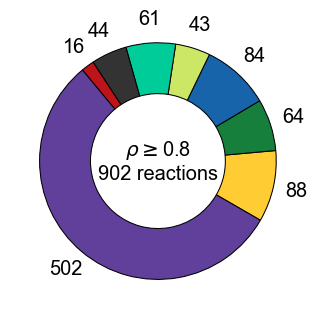

In [28]:
df_counts = df_abun_dep.copy()
abun_cutoff = "$\\rho \\geq$" + f"{abundance_dep_rho_lb}"

df_counts = df_counts["subsystem"].value_counts()
df_counts = (
    df_pathways[df_pathways["subsystem"] != "Pseudoreactions"][
        ["subsystem", "category"]
    ]
    .merge(
        df_counts,
        left_on="subsystem",
        right_on="subsystem",
        how="left",
    )
    .dropna()
)
df_counts["category"] = df_counts["category"].apply(
    lambda x: (
        "Other" if x not in categories_to_keep and x not in categories_to_exclude else x
    )
)
df_counts = df_counts.groupby(["category", "subsystem"])[["count"]].sum().astype(int)
df_counts = df_counts.reset_index(drop=False).sort_values(
    by=["category", "count"], ascending=[True, False]
)
df_counts_subsystem = df_counts.set_index("subsystem")
df_counts = df_counts.groupby(["category"]).agg(
    {"subsystem": lambda x: list(x), "count": "size"}
)

colors = {}
# Set colors
for category, (subsystems, size) in df_counts.iterrows():
    colors.update(
        dict(
            zip(
                subsystems,
                categories_to_keep[category](np.linspace(cmax - 0.1, cmin, size)),
            )
        )
    )

df_counts_subsystem["color"] = colors
df_counts_subsystem = df_counts_subsystem.reset_index(drop=False)
df_counts_category = df_counts_subsystem.groupby("category")[["count"]].sum()
df_counts_category["color"] = category_colors
df_counts_category["abbrev"] = {k: abbrevs[k] for k in df_counts_category.index}
df_counts_category = df_counts_category.reset_index(drop=False)


df_ring0, df_ring1 = df_counts_category, df_counts_subsystem
fig_ring, ax_ring = plt.subplots(1, 1, figsize=(3.3, 3.3))

wedgesize = 0.43
radius = 1
startangle = -30
linewidth = 0.75
edgecolor = "k"
labeldistance = 1.2

# ring_idx = 1
# labeldistance += wedgesize
# ax_ring.pie(
#     df_ring1["count"].values,
#     radius=radius + (ring_idx * wedgesize),
#     colors=df_ring1["color"].values,
#     # labels=df_ring1["name"].values,
#     wedgeprops=dict(
#         width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
#     ),
#     textprops={"fontsize": "large", "va": "center", "ha": "center"},
#     startangle=startangle,
# )
# Use for nice legend
labels = [
    "{}({})".format(k, v)
    for k, v in zip(
        df_ring0["abbrev"].values if use_abbrevs else df_ring0["category"].values,
        df_ring0["count"].values,
    )
]
ring_idx = 0
total = df_ring0["count"].sum()

ax_ring.pie(
    df_ring0["count"].values,
    radius=radius + (ring_idx * wedgesize),
    colors=df_ring0["color"].values,
    wedgeprops=dict(
        width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
    ),
    textprops={"fontsize": "x-large", "va": "center", "ha": "center"},
    startangle=startangle,
    labeldistance=labeldistance,
    labels=df_ring0["count"].values,
)
ax_ring.annotate(
    text=f"{abun_cutoff}\n{total} reactions",
    xy=(0, 0),
    transform=ax.transAxes,
    ha="center",
    va="center",
    fontsize="x-large",
)
fig_ring.tight_layout()
if save_figures:
    fig_ring.savefig(
        f"{figures_path}/Fig5_PanelH_AbunDepReactions.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig_ring;

##### Genes/Proteins

(18, 10)


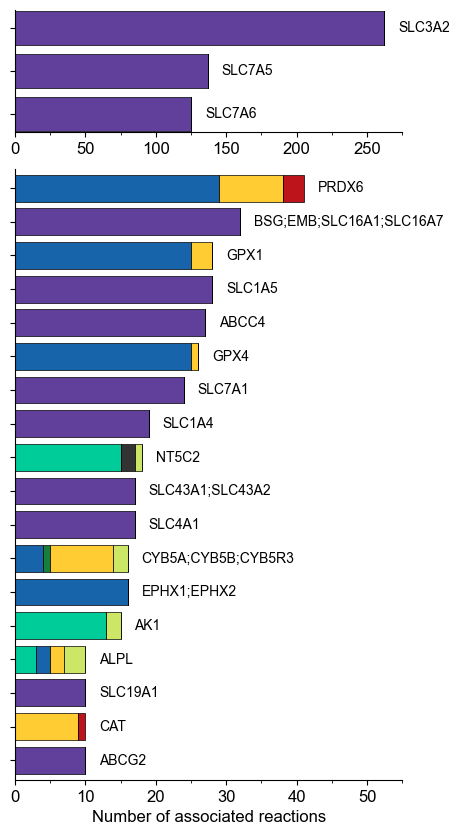

In [29]:
ticklabels_on_bars = True
hits_seperator = 50
cutoff = 10
df = df_abun_dep.copy()
df["genes"] = df["genes"].apply(split_string)
df = df.explode("genes")
list_of_genes = list(df["genes"].unique())
list_of_categories = list(df["category"].unique())

df_main = (
    pd.DataFrame.from_dict(
        {
            gene: df[df["genes"] == gene]["category"].value_counts().to_dict()
            for gene in list_of_genes
        },
        orient="index",
    )
    .fillna(0)
    .astype(int)
)
df_main.index.name = "genes"
df_main = pd.concat(
    (
        df_main,
        df.groupby("genes")["reaction"].agg(lambda x: tuple(list(x.unique()))),
    ),
    axis=1,
).reset_index(drop=False)
df_main = df_main.set_index("genes")
df_to_group = df_main[df_main.duplicated(keep=False)].reset_index(drop=False)
df_to_group = (
    df_to_group.groupby(list(df_to_group.columns[1:]))
    .agg(
        {
            "genes": lambda x: build_string(x),
        }
    )
    .reset_index(drop=False)
)
df_main = pd.concat(
    (
        df_main[~df_main.duplicated(keep=False)],
        df_to_group.set_index("genes"),
    ),
    axis=0,
)
df_main["total"] = df_main.loc[:, list_of_categories].sum(axis=1)
df_main = df_main.sort_values(by="total", ascending=False)
df_top_hits = df_main[df_main["total"] >= cutoff]
df_bot_hits = df_main[df_main["total"] < cutoff]

df_main = df_main[df_main["total"] >= cutoff]
df_upper = df_top_hits[df_top_hits["total"] > hits_seperator].sort_values(
    by="total", ascending=True
)
df_main = df_top_hits[df_top_hits["total"] <= hits_seperator]

print(df_main.shape)
df_main = df_main.sort_values(by="total", ascending=True)

if not df_upper.empty:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(5, 10),
        height_ratios=[len(df_upper) / len(df_main), 1 - len(df_upper) / len(df_main)],
        gridspec_kw=dict(hspace=0.1),
    )
    ax_upper, ax_main = axes.flatten()
else:
    fig, ax_main = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    ax_upper = None

df = df_main
ax = ax_main
scalar = 1
offset = np.zeros(len(df.index))
height = 0.8
for i, category in enumerate(list_of_categories):
    series = df[category]
    color = category_colors[category]
    rects = ax.barh(
        np.arange(0, len(series.index)) * 1,
        series.values,
        tick_label=series.index,
        height=height,
        left=offset,
        color=color,
        edgecolor="black",
        linewidth=0.5,
    )
    offset += series.values
    if i == len(list_of_categories) - 1 and ticklabels_on_bars:
        ax.bar_label(rects, series.index, padding=10)
        ax.set_yticklabels([])

ax.set_ymargin(0.01)
ax.set_xlim((0, scalar * 60 - 5))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(scalar * 10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(scalar * 10 / 2))
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="medium")
ax.set_xlabel("Number of associated reactions", fontsize="large")

if not df_upper.empty:
    df = df_upper
    ax = ax_upper
    scalar = 5
    offset = np.zeros(len(df.index))
    for i, category in enumerate(list_of_categories):
        series = df[category]
        color = category_colors[category]
        rects = ax.barh(
            np.arange(0, len(series.index)) * 1.0,
            series.values,
            tick_label=series.index,
            height=height,
            left=offset,
            color=color,
            edgecolor="black",
            linewidth=0.5,
        )
        offset += series.values
        if i == len(list_of_categories) - 1 and ticklabels_on_bars:
            ax.bar_label(rects, series.index, padding=10)
            ax.set_yticklabels([])
    ax.set_ymargin(0.01)
    ax.set_xlim((0, (scalar + 1) * 50 - 25))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(scalar * 10))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(scalar * 10 / 2))
    ax.yaxis.set_tick_params
    ax.xaxis.set_tick_params(labelsize="large")
    ax.yaxis.set_tick_params(labelsize="large")

sns.despine(fig)

if save_figures:
    fig.savefig(
        f"{figures_path}/Fig5_PanelI_AbunDepProteins.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

#### Abundance correlated
##### Reactions

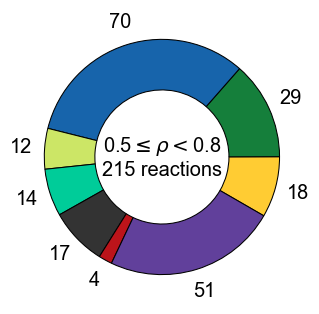

In [30]:
df_counts = df_abun_cor.copy()
abun_cutoff = f"{abundance_cor_rho_lb}" + "$\\leq \\rho <$" + f"{abundance_dep_rho_lb}"

df_counts = df_counts["subsystem"].value_counts()
df_counts = (
    df_pathways[df_pathways["subsystem"] != "Pseudoreactions"][
        ["subsystem", "category"]
    ]
    .merge(
        df_counts,
        left_on="subsystem",
        right_on="subsystem",
        how="left",
    )
    .dropna()
)
df_counts["category"] = df_counts["category"].apply(
    lambda x: (
        "Other" if x not in categories_to_keep and x not in categories_to_exclude else x
    )
)
df_counts = df_counts.groupby(["category", "subsystem"])[["count"]].sum().astype(int)
df_counts = df_counts.reset_index(drop=False).sort_values(
    by=["category", "count"], ascending=[True, False]
)
df_counts_subsystem = df_counts.set_index("subsystem")
df_counts = df_counts.groupby(["category"]).agg(
    {"subsystem": lambda x: list(x), "count": "size"}
)

colors = {}
# Set colors
for category, (subsystems, size) in df_counts.iterrows():
    colors.update(
        dict(
            zip(
                subsystems,
                categories_to_keep[category](np.linspace(cmax - 0.1, cmin, size)),
            )
        )
    )

df_counts_subsystem["color"] = colors
df_counts_subsystem = df_counts_subsystem.reset_index(drop=False)
df_counts_category = df_counts_subsystem.groupby("category")[["count"]].sum()
df_counts_category["color"] = category_colors
df_counts_category["abbrev"] = {k: abbrevs[k] for k in df_counts_category.index}
df_counts_category = df_counts_category.reset_index(drop=False)


df_ring0, df_ring1 = df_counts_category, df_counts_subsystem
fig_ring, ax_ring = plt.subplots(1, 1, figsize=(3.3, 3.3))

wedgesize = 0.43
radius = 1
startangle = -30
linewidth = 0.75
edgecolor = "k"
labeldistance = 1.2

# ring_idx = 1
# labeldistance += wedgesize
# ax_ring.pie(
#     df_ring1["count"].values,
#     radius=radius + (ring_idx * wedgesize),
#     colors=df_ring1["color"].values,
#     # labels=df_ring1["name"].values,
#     wedgeprops=dict(
#         width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
#     ),
#     textprops={"fontsize": "large", "va": "center", "ha": "center"},
#     startangle=startangle,
# )
# Use for nice legend
labels = [
    "{}({})".format(k, v)
    for k, v in zip(
        df_ring0["abbrev"].values if use_abbrevs else df_ring0["category"].values,
        df_ring0["count"].values,
    )
]
ring_idx = 0
total = df_ring0["count"].sum()

ax_ring.pie(
    df_ring0["count"].values,
    radius=radius + (ring_idx * wedgesize),
    colors=df_ring0["color"].values,
    wedgeprops=dict(
        width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
    ),
    textprops={"fontsize": "x-large", "va": "center", "ha": "center"},
    startangle=startangle,
    labeldistance=labeldistance,
    labels=df_ring0["count"].values,
)
ax_ring.annotate(
    text=f"{abun_cutoff}\n{total} reactions",
    xy=(0, 0),
    transform=ax.transAxes,
    ha="center",
    va="center",
    fontsize="x-large",
)
fig_ring.tight_layout()
if save_figures:
    fig_ring.savefig(
        f"{figures_path}/Fig5_PanelH_ExprCorReactions.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig_ring;

##### Genes/Proteins

(20, 10)


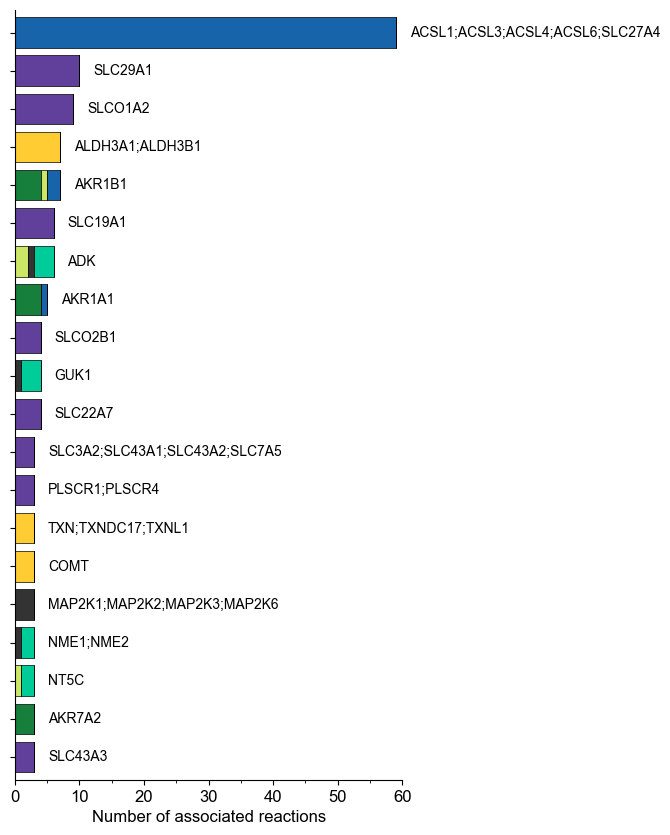

In [31]:
ticklabels_on_bars = True
hits_seperator = 60
cutoff = 3
df = df_abun_cor.copy()
df["genes"] = df["genes"].apply(split_string)
df = df.explode("genes")
list_of_genes = list(df["genes"].unique())
list_of_categories = list(df["category"].unique())

df_main = (
    pd.DataFrame.from_dict(
        {
            gene: df[df["genes"] == gene]["category"].value_counts().to_dict()
            for gene in list_of_genes
        },
        orient="index",
    )
    .fillna(0)
    .astype(int)
)
df_main.index.name = "genes"
df_main = pd.concat(
    (
        df_main,
        df.groupby("genes")["reaction"].agg(lambda x: tuple(list(x.unique()))),
    ),
    axis=1,
).reset_index(drop=False)
df_main = df_main.set_index("genes")
df_to_group = df_main[df_main.duplicated(keep=False)].reset_index(drop=False)
df_to_group = (
    df_to_group.groupby(list(df_to_group.columns[1:]))
    .agg(
        {
            "genes": lambda x: build_string(x),
        }
    )
    .reset_index(drop=False)
)
df_main = pd.concat(
    (
        df_main[~df_main.duplicated(keep=False)],
        df_to_group.set_index("genes"),
    ),
    axis=0,
)
df_main["total"] = df_main.loc[:, list_of_categories].sum(axis=1)
df_main = df_main.sort_values(by="total", ascending=False)
df_top_hits = df_main[df_main["total"] >= cutoff]
df_bot_hits = df_main[df_main["total"] < cutoff]

df_main = df_main[df_main["total"] >= cutoff]
df_upper = df_top_hits[df_top_hits["total"] > hits_seperator].sort_values(
    by="total", ascending=True
)
df_main = df_top_hits[df_top_hits["total"] <= hits_seperator]

print(df_main.shape)
df_main = df_main.sort_values(by="total", ascending=True)

if not df_upper.empty:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(5, 10),
        height_ratios=[len(df_upper) / len(df_main), 1 - len(df_upper) / len(df_main)],
        gridspec_kw=dict(hspace=0.1),
    )
    ax_upper, ax_main = axes.flatten()
else:
    fig, ax_main = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    ax_upper = None

df = df_main
ax = ax_main
scalar = 1
offset = np.zeros(len(df.index))
height = 0.8
for i, category in enumerate(list_of_categories):
    series = df[category]
    color = category_colors[category]
    rects = ax.barh(
        np.arange(0, len(series.index)) * 1,
        series.values,
        tick_label=series.index,
        height=height,
        left=offset,
        color=color,
        edgecolor="black",
        linewidth=0.5,
    )
    offset += series.values
    if i == len(list_of_categories) - 1 and ticklabels_on_bars:
        ax.bar_label(rects, series.index, padding=10)
        ax.set_yticklabels([])

ax.set_ymargin(0.01)
ax.set_xlim((0, scalar * hits_seperator))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(scalar * 10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(scalar * 10 / 2))
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="medium")
ax.set_xlabel("Number of associated reactions", fontsize="large")

if not df_upper.empty:
    df = df_upper
    ax = ax_upper
    scalar = 5
    offset = np.zeros(len(df.index))
    for i, category in enumerate(list_of_categories):
        series = df[category]
        color = category_colors[category]
        rects = ax.barh(
            np.arange(0, len(series.index)) * 1.0,
            series.values,
            tick_label=series.index,
            height=height,
            left=offset,
            color=color,
            edgecolor="black",
            linewidth=0.5,
        )
        offset += series.values
        if i == len(list_of_categories) - 1 and ticklabels_on_bars:
            ax.bar_label(rects, series.index, padding=10)
            ax.set_yticklabels([])
    ax.set_ymargin(0.01)
    ax.set_xlim((0, (scalar + 1) * 50 - 25))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(scalar * 10))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(scalar * 10 / 2))
    ax.yaxis.set_tick_params
    ax.xaxis.set_tick_params(labelsize="large")
    ax.yaxis.set_tick_params(labelsize="large")

sns.despine(fig)

# if save_figures:
# fig.savefig(
#     f"{figures_path}/Fig5_Panel_ExprDepProteins.{imagetype}",
#     transparent=transparent,
#     format=imagetype,
# )
fig;

In [32]:
df_top_hits.head(10)

,Transport reactions,Amino acid metabolism,Carbohydrate metabolism,Lipid metabolism,Metabolism of cofactors and vitamins,Other,Nucleotide metabolism,Reactive species,reaction,total
genes,,,,,,,,,,
ACSL1;ACSL3;ACSL4;ACSL6;SLC27A4,0,0,0,59,0,0,0,0,"(FACOAL_12_0, FACOAL_13_0, FACOAL_14_0, FACOAL...",59
SLC29A1,10,0,0,0,0,0,0,0,"(THYMt, URAt, ADNt, ADEt, 2DINSt, RNAMt, 2DURI...",10
SLCO1A2,9,0,0,0,0,0,0,0,"(DHEASte, DGCHOLte, GCHOLAte, GDCHOLAte, GUDCH...",9
ALDH3A1;ALDH3B1,0,7,0,0,0,0,0,0,"(34DHALDDx, 3M4HDXPACx, MACOXO, 34DHALDDy, 3M4...",7
AKR1B1,0,0,4,2,1,0,0,0,"(LALD_Ly, ALR2y, ALR3y, PPDOy, PGH2Ry, ALCD19y...",7
SLC19A1,6,0,0,0,0,0,0,0,"(5FTHF_THMMPtex, 5MTHF_THMMPtex, THF_THMMPtex,...",6
ADK,0,0,0,0,2,1,3,0,"(AICAK, 4PYRNK, RBVK, ADNK1, DADNK1, NRHK)",6
AKR1A1,0,0,4,1,0,0,0,0,"(ALR2y, ALR3y, PPDOy, GULND, ALCD19y)",5
SLCO2B1,4,0,0,0,0,0,0,0,"(DHEASte, CHOLATEt, TCHOLAte, CPPP3te)",4


#### Abundance independent
##### Reactions

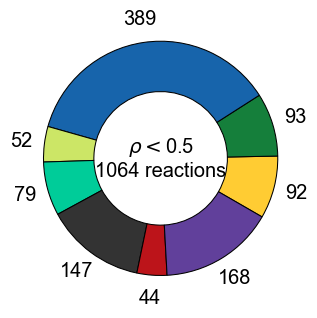

In [33]:
df_counts = pd.concat((df_abun_ind, df_blocked_w_abun), axis=0)
abun_cutoff = abundance_cor_rho_lb
abun_cutoff = "$\\rho <$" + f"{abundance_cor_rho_lb}"

df_counts = df_counts["subsystem"].value_counts()
df_counts = (
    df_pathways[df_pathways["subsystem"] != "Pseudoreactions"][
        ["subsystem", "category"]
    ]
    .merge(
        df_counts,
        left_on="subsystem",
        right_on="subsystem",
        how="left",
    )
    .dropna()
)
df_counts["category"] = df_counts["category"].apply(
    lambda x: (
        "Other" if x not in categories_to_keep and x not in categories_to_exclude else x
    )
)
df_counts = df_counts.groupby(["category", "subsystem"])[["count"]].sum().astype(int)
df_counts = df_counts.reset_index(drop=False).sort_values(
    by=["category", "count"], ascending=[True, False]
)
df_counts_subsystem = df_counts.set_index("subsystem")
df_counts = df_counts.groupby(["category"]).agg(
    {"subsystem": lambda x: list(x), "count": "size"}
)

colors = {}
# Set colors
for category, (subsystems, size) in df_counts.iterrows():
    colors.update(
        dict(
            zip(
                subsystems,
                categories_to_keep[category](np.linspace(cmax - 0.1, cmin, size)),
            )
        )
    )

df_counts_subsystem["color"] = colors
df_counts_subsystem = df_counts_subsystem.reset_index(drop=False)
df_counts_category = df_counts_subsystem.groupby("category")[["count"]].sum()
df_counts_category["color"] = category_colors
df_counts_category["abbrev"] = {k: abbrevs[k] for k in df_counts_category.index}
df_counts_category = df_counts_category.reset_index(drop=False)


df_ring0, df_ring1 = df_counts_category, df_counts_subsystem
fig_ring, ax_ring = plt.subplots(1, 1, figsize=(3.3, 3.3))

wedgesize = 0.43
radius = 1
startangle = -30
linewidth = 0.75
edgecolor = "k"
labeldistance = 1.2

# ring_idx = 1
# labeldistance += wedgesize
# ax_ring.pie(
#     df_ring1["count"].values,
#     radius=radius + (ring_idx * wedgesize),
#     colors=df_ring1["color"].values,
#     # labels=df_ring1["name"].values,
#     wedgeprops=dict(
#         width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
#     ),
#     textprops={"fontsize": "large", "va": "center", "ha": "center"},
#     startangle=startangle,
# )
# Use for nice legend
labels = [
    "{}({})".format(k, v)
    for k, v in zip(
        df_ring0["abbrev"].values if use_abbrevs else df_ring0["category"].values,
        df_ring0["count"].values,
    )
]
ring_idx = 0
total = df_ring0["count"].sum()

ax_ring.pie(
    df_ring0["count"].values,
    radius=radius + (ring_idx * wedgesize),
    colors=df_ring0["color"].values,
    wedgeprops=dict(
        width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
    ),
    textprops={"fontsize": "x-large", "va": "center", "ha": "center"},
    startangle=startangle,
    labeldistance=labeldistance,
    labels=df_ring0["count"].values,
)
ax_ring.annotate(
    text=f"{abun_cutoff}\n{total} reactions",
    xy=(0, 0),
    transform=ax.transAxes,
    ha="center",
    va="center",
    fontsize="x-large",
)
fig_ring.tight_layout()
if save_figures:
    fig_ring.savefig(
        f"{figures_path}/Fig5_Panel_AbunIndepProteins.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig_ring;

(56, 10)


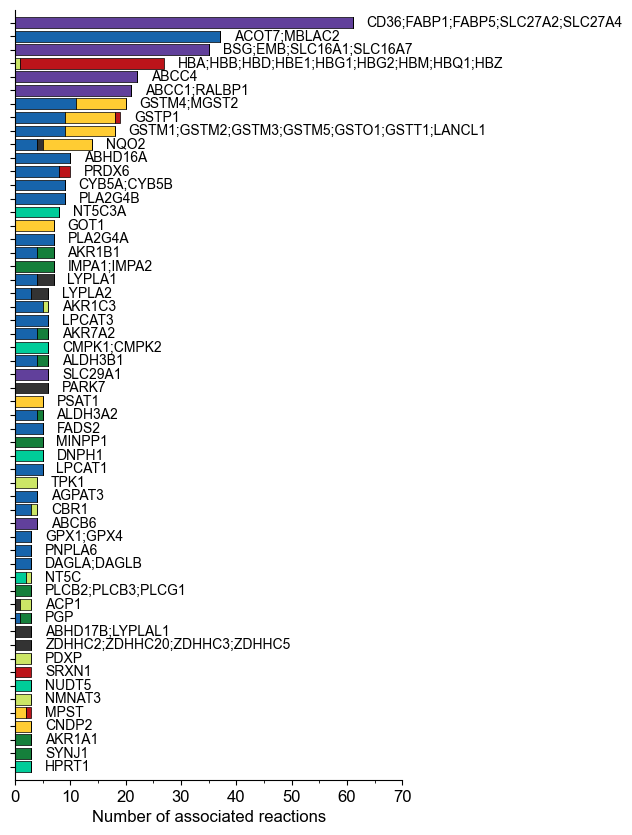

In [34]:
ticklabels_on_bars = True
hits_seperator = 70
cutoff = 3
df = df_abun_ind.copy()
df["genes"] = df["genes"].apply(split_string)
df = df.explode("genes")
list_of_genes = list(df["genes"].unique())
list_of_categories = list(df["category"].unique())

df_main = (
    pd.DataFrame.from_dict(
        {
            gene: df[df["genes"] == gene]["category"].value_counts().to_dict()
            for gene in list_of_genes
        },
        orient="index",
    )
    .fillna(0)
    .astype(int)
)
df_main.index.name = "genes"
df_main = pd.concat(
    (
        df_main,
        df.groupby("genes")["reaction"].agg(lambda x: tuple(list(x.unique()))),
    ),
    axis=1,
).reset_index(drop=False)
df_main = df_main.set_index("genes")
df_to_group = df_main[df_main.duplicated(keep=False)].reset_index(drop=False)
df_to_group = (
    df_to_group.groupby(list(df_to_group.columns[1:]))
    .agg(
        {
            "genes": lambda x: build_string(x),
        }
    )
    .reset_index(drop=False)
)
df_main = pd.concat(
    (
        df_main[~df_main.duplicated(keep=False)],
        df_to_group.set_index("genes"),
    ),
    axis=0,
)
df_main["total"] = df_main.loc[:, list_of_categories].sum(axis=1)
df_main = df_main.sort_values(by="total", ascending=False)
df_top_hits = df_main[df_main["total"] >= cutoff]
df_bot_hits = df_main[df_main["total"] < cutoff]

df_main = df_main[df_main["total"] >= cutoff]
df_upper = df_top_hits[df_top_hits["total"] > hits_seperator].sort_values(
    by="total", ascending=True
)
df_main = df_top_hits[df_top_hits["total"] <= hits_seperator]

print(df_main.shape)
df_main = df_main.sort_values(by="total", ascending=True)

if not df_upper.empty:
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(5, 10),
        height_ratios=[len(df_upper) / len(df_main), 1 - len(df_upper) / len(df_main)],
        gridspec_kw=dict(hspace=0.1),
    )
    ax_upper, ax_main = axes.flatten()
else:
    fig, ax_main = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    ax_upper = None

df = df_main
ax = ax_main
scalar = 1
offset = np.zeros(len(df.index))
height = 0.8
for i, category in enumerate(list_of_categories):
    series = df[category]
    color = category_colors[category]
    rects = ax.barh(
        np.arange(0, len(series.index)) * 1,
        series.values,
        tick_label=series.index,
        height=height,
        left=offset,
        color=color,
        edgecolor="black",
        linewidth=0.5,
    )
    offset += series.values
    if i == len(list_of_categories) - 1 and ticklabels_on_bars:
        ax.bar_label(rects, series.index, padding=10)
        ax.set_yticklabels([])

ax.set_ymargin(0.01)
ax.set_xlim((0, scalar * hits_seperator))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(scalar * 10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(scalar * 10 / 2))
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="medium")
ax.set_xlabel("Number of associated reactions", fontsize="large")

if not df_upper.empty:
    df = df_upper
    ax = ax_upper
    scalar = 5
    offset = np.zeros(len(df.index))
    for i, category in enumerate(list_of_categories):
        series = df[category]
        color = category_colors[category]
        rects = ax.barh(
            np.arange(0, len(series.index)) * 1.0,
            series.values,
            tick_label=series.index,
            height=height,
            left=offset,
            color=color,
            edgecolor="black",
            linewidth=0.5,
        )
        offset += series.values
        if i == len(list_of_categories) - 1 and ticklabels_on_bars:
            ax.bar_label(rects, series.index, padding=10)
            ax.set_yticklabels([])
    ax.set_ymargin(0.01)
    ax.set_xlim((0, (scalar + 1) * 50 - 25))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(scalar * 10))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(scalar * 10 / 2))
    ax.yaxis.set_tick_params
    ax.xaxis.set_tick_params(labelsize="large")
    ax.yaxis.set_tick_params(labelsize="large")

sns.despine(fig)

# if save_figures:
#     fig.savefig(
#         f"{figures_path}/Fig5_Panel_AbunIndepProteins.{imagetype}",
#         transparent=transparent,
#         format=imagetype,
#     )
fig;

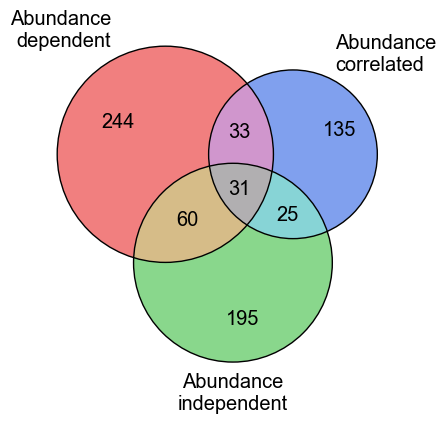

In [35]:
df = df_abun_dep.copy()
df["genes"] = df["genes"].apply(split_string)
df = df.explode("genes")
dep_genes = set(df["genes"].unique())
dep_genes

df = df_abun_cor.copy()
df["genes"] = df["genes"].apply(split_string)
df = df.explode("genes")
cor_genes = set(df["genes"].unique())

df = df_abun_ind.copy()
df["genes"] = df["genes"].apply(split_string)
df = df.explode("genes")
ind_genes = set(df["genes"].unique())

venn = mpl_venn.venn3(
    subsets=[dep_genes, cor_genes, ind_genes],
    set_labels=[
        "Abundance\ndependent",
        "Abundance\ncorrelated",
        "Abundance\nindependent",
    ],
    set_colors=("xkcd:red", "xkcd:blue", "xkcd:green"),
    alpha=0.5,
    # ax=ax1,
)
circles = mpl_venn.venn3_circles(
    subsets=[dep_genes, cor_genes, ind_genes], linestyle="-", color="black", linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")

#### Compute correlation matrices for correlations between fluxes and correlation between abundances

In [ ]:
df_flux = df_reaction_flux_abundance.pivot(
    columns="model", index="reactions", values="Flux"
)
df_flux_corr_all = df_flux.T.corr(method="spearman")
df_flux_corr_all.to_csv(
    f"{dataset_path}/{pcmodel.id}_{dataset_name}_FLUX_CORR_MAT.tsv",
    sep="\t",
    index=True,
)
nan_list = list(df_flux_corr_all.index[~df_flux_corr_all.isna().all(axis=0)])
df_flux_corr = df_flux_corr_all.loc[nan_list, nan_list]


df_abun = df_reaction_flux_abundance.pivot(
    columns="model", index="reactions", values="Abundance"
)
df_abun_corr_all = df_abun.T.corr(method="spearman")
df_abun_corr = df_abun_corr_all.loc[nan_list, nan_list]

##### Visualize

In [ ]:
df = sorted(
    df_flux_corr.index,
    key=lambda x: (mapping_dict[model.reactions.get_by_id(x).subsystem], x),
)
df = df_flux_corr.loc[df]
fig = sns.clustermap(
    df,
    figsize=(20, 12),
    cmap="coolwarm",
    row_cluster=True,
    col_cluster=True,
    row_colors=[
        category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]]
        for x in df.index
    ],
    col_colors=[
        category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]]
        for x in df.index
    ],
)
fig.data.to_csv(
    f"{dataset_path}/{pcmodel.id}_{dataset_name}_FLUX_CORR_MAT.tsv",
    sep="\t",
    index=True,
)
ax_heatmap = fig.ax_heatmap
ax_heatmap.set_xlabel("Reactions", fontsize="x-large")
ax_heatmap.xaxis.set_ticklabels([])

ax_heatmap.set_ylabel("Reactions", fontsize="x-large")
ax_heatmap.yaxis.set_ticklabels([])
fig.ax_row_dendrogram.set_visible(False)
fig.ax_col_dendrogram.set_visible(False)
fig.data

In [ ]:
df = sorted(
    df_abun_corr.index,
    key=lambda x: (mapping_dict[model.reactions.get_by_id(x).subsystem], x),
)
df = df_abun_corr.loc[df]
fig = sns.clustermap(
    df,
    figsize=(20, 12),
    cmap="coolwarm",
    row_cluster=True,
    col_cluster=True,
    row_colors=[
        category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]]
        for x in df.index
    ],
    col_colors=[
        category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]]
        for x in df.index
    ],
)
fig.data.to_csv(
    f"{dataset_path}/{pcmodel.id}_{dataset_name}_ABUN_CORR_MAT.tsv",
    sep="\t",
    index=True,
)
ax_heatmap = fig.ax_heatmap
ax_heatmap.set_xlabel("Reactions", fontsize="x-large")
ax_heatmap.xaxis.set_ticklabels([])

ax_heatmap.set_ylabel("Reactions", fontsize="x-large")
ax_heatmap.yaxis.set_ticklabels([])
fig.ax_row_dendrogram.set_visible(False)
fig.ax_col_dendrogram.set_visible(False)
fig.data

### Visualize selected flux results

In [ ]:
# DataFrame for flux values
group_name = "OPERATIONS"
sort_by = ["time", "sample"]
df_flux_all = dict_of_dataframes_types["reactions"].copy()
# df_flux_all = df_flux_all[df_flux_all["model"].isin(model_groups[group_name])]
df_flux_all["time"] = df_flux_all["model"].apply(
    lambda x: get_time_from_id(x, time_prefix=time_prefix)
)
df_flux_all["sample"] = df_flux_all["model"].apply(
    lambda x: get_sample_from_id(x, sample_prefix=sample_prefix)
)
df_flux_all = df_flux_all.sort_values(by=sort_by)

# DataFrame for abundance values
df_abun_all = dict_of_dataframes_types["enzymes"].copy()
# df_abun = df_abun[df_abun["model"].isin(model_groups[group_name])]
df_abun_all["time"] = df_abun_all["model"].apply(
    lambda x: get_time_from_id(x, time_prefix=time_prefix)
)
df_abun_all["sample"] = df_abun_all["model"].apply(
    lambda x: get_sample_from_id(x, sample_prefix=sample_prefix)
)
df_abun_all = df_abun_all.sort_values(by=sort_by)

df_abun_all["reactions"] = df_abun_all["reactions"].apply(
    lambda x: enzyme_reaction_map[x]
)
df_abun_all = df_abun_all.groupby(
    ["reactions", "model", "time", "sample"], as_index=False
)["maximum"].max()

In [ ]:
flux_group_name = "Glycolysis"  # If using same cell for multiple different file exports, change flux_group_name to prevent file overlap


optimum_colors = {
    0.00: "xkcd:green",
    0.50: "xkcd:dark yellow",
    0.90: "xkcd:orange",
    0.99: "xkcd:red",
}
timepoint_colors = {
    "Day 10": "xkcd:white",
    "Day 23": "xkcd:light blue",
    "Day 42": "xkcd:light purple",
}

# Leave empty to remove
vline_samples = {
    # "Mean": {"color": "black", "linestyle": "--"},
    # "Median": {"color": "black", "linestyle": ":"},
}
equilibrium_line = {"color": "black", "linestyle": ":"}


legend_at_bottom = False
time_order_results = True
rank_order_results = True
sample_order_results = True  # Ignored if rank ordering
sharex, sharey = (True, True)
obj_rxn = model.reactions.query(lambda x: x.objective_coefficient)[0]

fluxes_to_plot = np.array(
    [
        ["HEX1", "PGI", "PFK", "TPI", "FBA"],  # Glycolysis
        ["GAPD", "PGK", "PGM", "ENO", "PYK"],  # Glycolysis
        ["LDH_L", "DPGM", "DPGase", "HB23DPGB", "NaKt"],  # Hemoglobin and objective
        ["HEX1a", "GLCM", "G6PM", "", ""],  # Hemoglobin and objective
    ]
)


column_pair = ("Flux", "Abundance")
df_rho = spearman_rankings_group_dict["ALL"][column_pair]["rho"]
df_fluxes_to_plot = df_flux_all[
    df_flux_all["reactions"].isin(fluxes_to_plot.flatten())
].copy()
df_abun_to_plot = df_abun_all[
    df_abun_all["reactions"].isin(fluxes_to_plot.flatten())
].copy()
df_fluxes_to_plot["span"] = df_fluxes_to_plot["maximum"] - df_fluxes_to_plot["minimum"]

# Remove mean and medians if not desired
df_fluxes_to_plot = df_fluxes_to_plot[
    ~df_fluxes_to_plot["sample"].isin(
        [
            "Mean" if "Mean" not in vline_samples else "",
            "Median" if "Median" not in vline_samples else "",
        ]
    )
]

timepoints = df_fluxes_to_plot["time"].unique()
samples = df_fluxes_to_plot["sample"].unique()
optimums = df_fluxes_to_plot["optimum"].unique()
index_points = np.arange(1, (len(samples) * len(timepoints)) + 1)

sort_by = {}
if time_order_results:
    sort_by["time"] = True
if rank_order_results:
    sort_by["span"] = True
    sort_by["maximum"] = True
    sort_by["minimum"] = True
if sample_order_results:
    sort_by["sample"] = True


nrows, ncols = fluxes_to_plot.shape
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 2 * nrows),
    sharex=sharex,
    sharey=sharey,
)
axes = np.atleast_2d(axes)

mid_col_ind = int(np.ceil(axes.shape[1] / 2)) - 1
mid_row_ind = int(np.ceil(axes.shape[0] / 2)) - 1
for rid, ax in zip(fluxes_to_plot.flatten(), axes.flatten()):
    if not rid:
        fig.delaxes(ax)
        continue
    df_flux_rxn = df_fluxes_to_plot[df_fluxes_to_plot["reactions"] == rid].reset_index(
        drop=True
    )
    ymin_v, ymax_v = (
        df_fluxes_to_plot["minimum"].min() if sharey else df_flux_rxn["minimum"].min(),
        df_fluxes_to_plot["maximum"].max() if sharey else df_flux_rxn["maximum"].max(),
    )
    ypad_v = (
        df_fluxes_to_plot[["maximum", "minimum"]].abs().max(axis=1).max()
        if sharey
        else df_flux_rxn[["maximum", "minimum"]].abs().max(axis=1).max()
    ) * 0.05

    if time_order_results:
        for multiplier, (timepoint, color) in enumerate(timepoint_colors.items()):
            offset = 0
            xmin = multiplier * len(samples) - offset
            xmax = (multiplier + 1) * len(samples) - offset

            if multiplier != 0:
                ax.vlines(
                    x=xmin,
                    ymin=ymin_v - ypad_v,
                    ymax=ymax_v + ypad_v,
                    linestyle="-",
                    color="black",
                    linewidth=1.5,
                    zorder=5,
                )
            if (sharex and ax in axes[-1, :]) or not sharex:
                ax.text(
                    1 / 3 * multiplier + 1 / 3 / 2,
                    -0.15,  # Adjust to alter position  of Day 10, 23, 42
                    timepoint,
                    transform=ax.transAxes,
                    ha="center",
                    fontsize="large",
                )
                if sharex and ax == axes[-1, mid_col_ind]:
                    ax.set_xlabel("Samples", labelpad=20, fontsize="xx-large")

    rho = f"{df_rho.loc[rid]:.3f}" if rid in df_rho else "\\text{NaN}"

    ax.set_title(f"{rid} $(\\rho = {rho})$", fontsize="large")
    ax.set_xticks([])
    ax.set_xlim((0 - offset, len(index_points) - offset))
    ax.set_ylim((ymin_v - ypad_v, ymax_v + ypad_v))

    for optimum, color in optimum_colors.items():
        df_flux_rxn_opt = df_flux_rxn[df_flux_rxn["optimum"] == optimum]
        df_flux_rxn_opt = df_flux_rxn_opt.sort_values(
            by=list(sort_by.keys()), ascending=list(sort_by.values())
        )
        df_flux_rxn_opt = df_flux_rxn_opt.set_index(["time", "sample"])
        lower_line = ax.plot(
            index_points,
            df_flux_rxn_opt["minimum"].values,
            color=color,
            linestyle="-",
            linewidth=2,
        )
        upper_line = ax.plot(
            index_points,
            df_flux_rxn_opt["maximum"].values,
            color=color,
            linestyle="-",
            linewidth=2,
        )
        ax.fill_between(
            index_points,
            df_flux_rxn_opt["minimum"].values,
            df_flux_rxn_opt["maximum"].values,
            color=color,
            alpha=1,
        )

    for sample_id, options in vline_samples.items():
        color = options["color"]
        linestyle = options["linestyle"]
        indicies = [
            i
            for i, (time, sample) in enumerate(df_flux_rxn_opt.index)
            if sample == sample_id
        ]
        for sample_index in index_points[indicies]:
            ax.vlines(
                x=sample_index,
                ymin=ymin - ypad,
                ymax=ymax + ypad,
                linestyle=linestyle,
                color=color,
                linewidth=1,
                zorder=4,
            )
    if equilibrium_line:
        ax.hlines(
            0,
            index_points[0],
            index_points[-1],
            zorder=4,
            color=equilibrium_line["color"],
            linestyle=equilibrium_line["linestyle"],
            linewidth=1,
        )

    if ax == axes[mid_row_ind, 0]:
        ax.set_ylabel("Flux (mmol/gDW/hr)", fontsize="xx-large")
    ax.tick_params(axis="y", labelsize="x-large")

    if (ax == axes[mid_row_ind, -1] and not legend_at_bottom) or (
        ax == axes[-1, mid_col_ind] and legend_at_bottom
    ):
        legend_handles = [
            mpl.patches.Patch(
                facecolor=color,
                edgecolor="black",
                label=("  " if optimum < 0.1 else "")
                + (f"{optimum:.0%} Max. {obj_rxn.id}"),
            )
            for optimum, color in optimum_colors.items()
        ]
        legend_handles += [
            mpl.lines.Line2D(
                [0],
                [0],
                linestyle=options["linestyle"],
                color=options["color"],
                label=sample_id,
            )
            for sample_id, options in vline_samples.items()
        ]
        # if equilibrium_line:
        #     legend_handles += [mpl.lines.Line2D([0], [0], linestyle=equilibrium_line["linestyle"], color=equilibrium_line["color"], label="Equilibrium")]

        if legend_at_bottom:
            ax.legend(
                handles=legend_handles,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.3),
                fontsize="xx-large",
                ncols=len(legend_handles),
                frameon=False,
            )
        else:
            ax.legend(
                handles=legend_handles,
                loc="center left",
                bbox_to_anchor=(1, 0.5),
                fontsize="xx-large",
                ncols=1,
                frameon=False,
                alignment="right",
            )

plt.subplots_adjust(
    hspace=0.25 if sharex else 0.5,
    wspace=0.05 if sharey else 0.2,
)

if save_figures:
    fig.savefig(
        f"{figures_path}/SelectFluxRanges{flux_group_name}_{model.id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

In [ ]:
# flux_group_name = "PPP" # If using same cell for multiple different file exports, change flux_group_name to prevent file overlap


# optimum_colors = {
#     0.00: "xkcd:green",
#     0.50: "xkcd:dark yellow",
#     0.90: "xkcd:orange",
#     0.99: "xkcd:red",
# }
# timepoint_colors = {
#     "Day 10": "xkcd:white",
#     "Day 23": "xkcd:light blue",
#     "Day 42": "xkcd:light purple",
# }

# # Leave empty to remove
# vline_samples = {
#     # "Mean": {"color": "black", "linestyle": "--"},
#     # "Median": {"color": "black", "linestyle": ":"},
# }
# equilibrium_line = {
#     "color": "black", "linestyle": ":"
# }


# legend_at_bottom = False
# time_order_results = True
# rank_order_results = True
# sample_order_results = True # Ignored if rank ordering
# sharex, sharey = (True, True)
# obj_rxn = model.reactions.query(lambda x: x.objective_coefficient)[0]

# fluxes_to_plot = np.array([
#     ["G6PDH2", "PGL", "GND", "",  ""], # Pentose phosphate pathway
#     ["RPE", "RPI", "TALA", "TKT2", "TKT1"], # Pentose phosphate pathway
# ])


# column_pair = ("Flux", "Abundance")
# df_rho = spearman_rankings_group_dict["ALL"][column_pair]["rho"]
# df_fluxes_to_plot = df_flux_all[df_flux_all["reactions"].isin(fluxes_to_plot.flatten())].copy()
# df_abun_to_plot = df_abun_all[df_abun_all["reactions"].isin(fluxes_to_plot.flatten())].copy()
# df_fluxes_to_plot["span"] = df_fluxes_to_plot["maximum"] - df_fluxes_to_plot["minimum"]

# # Remove mean and medians if not desired
# df_fluxes_to_plot = df_fluxes_to_plot[~df_fluxes_to_plot["sample"].isin([
#    "Mean" if "Mean" not in vline_samples else "",
#    "Median" if "Median" not in vline_samples else "",
# ])]

# timepoints = df_fluxes_to_plot["time"].unique()
# samples = df_fluxes_to_plot["sample"].unique()
# optimums = df_fluxes_to_plot["optimum"].unique()
# index_points = np.arange(1, (len(samples) * len(timepoints)) + 1)

# sort_by = {}
# if time_order_results:
#     sort_by["time"] = True
# if rank_order_results:
#     sort_by["span"] = True
#     sort_by["maximum"] = True
#     sort_by["minimum"] = True
# if sample_order_results:
#     sort_by["sample"] = True


# nrows, ncols = fluxes_to_plot.shape
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 2*nrows), sharex=sharex, sharey=sharey)
# axes = np.atleast_2d(axes)

# mid_col_ind = int(np.ceil(axes.shape[1]/2))-1
# mid_row_ind = int(np.ceil(axes.shape[0]/2))-1
# for rid, ax in zip(fluxes_to_plot.flatten(), axes.flatten()):
#     if not rid:
#         fig.delaxes(ax)
#         continue
#     df_flux_rxn = df_fluxes_to_plot[df_fluxes_to_plot["reactions"] == rid].reset_index(drop=True)
#     ymin_v, ymax_v = (
#         df_fluxes_to_plot["minimum"].min() if sharey else df_flux_rxn["minimum"].min(),
#         df_fluxes_to_plot["maximum"].max() if sharey else df_flux_rxn["maximum"].max()
#     )
#     ypad_v = (
#         df_fluxes_to_plot[["maximum", "minimum"]].abs().max(axis=1).max() if sharey
#         else df_flux_rxn[["maximum", "minimum"]].abs().max(axis=1).max()
#     ) * 0.05

#     if time_order_results:
#         for multiplier, (timepoint, color) in enumerate(timepoint_colors.items()):
#             offset = 0
#             xmin = multiplier * len(samples) - offset
#             xmax = (multiplier + 1) * len(samples) - offset

#             if multiplier != 0:
#                 ax.vlines(
#                     x=xmin,
#                     ymin=ymin_v - ypad_v,
#                     ymax=ymax_v + ypad_v,
#                     linestyle="-",
#                     color="black",
#                     linewidth=1.5,
#                     zorder=5
#                 )
#             if (sharex and ax in axes[-1, :]) or not sharex:
#                 ax.text(
#                     1/3 * multiplier + 1/3/2,
#                     -0.15,  # Adjust to alter position  of Day 10, 23, 42
#                     timepoint,
#                     transform=ax.transAxes,
#                     ha="center",
#                     fontsize="large"
#                 )
#                 if (sharex and ax == axes[-1, mid_col_ind]):
#                     ax.set_xlabel("Samples", labelpad=20, fontsize="xx-large")

#     rho = f"{df_rho.loc[rid]:.3f}" if rid in df_rho else "\\text{NaN}"

#     ax.set_title(f"{rid} $(\\rho = {rho})$", fontsize="large")
#     ax.set_xticks([])
#     ax.set_xlim((0 - offset, len(index_points) - offset))
#     ax.set_ylim((ymin_v - ypad_v, ymax_v + ypad_v))

#     for optimum, color in optimum_colors.items():
#         df_flux_rxn_opt = df_flux_rxn[df_flux_rxn["optimum"] == optimum]
#         df_flux_rxn_opt = df_flux_rxn_opt.sort_values(by=list(sort_by.keys()), ascending=list(sort_by.values()))
#         df_flux_rxn_opt = df_flux_rxn_opt.set_index(["time", "sample"])
#         lower_line = ax.plot(index_points, df_flux_rxn_opt["minimum"].values, color=color, linestyle="-", linewidth=2)
#         upper_line = ax.plot(index_points, df_flux_rxn_opt["maximum"].values, color=color, linestyle="-", linewidth=2)
#         ax.fill_between(index_points, df_flux_rxn_opt["minimum"].values, df_flux_rxn_opt["maximum"].values, color=color, alpha=1)

#     for sample_id, options in vline_samples.items():
#         color = options["color"]
#         linestyle = options["linestyle"]
#         indicies = [i for i, (time, sample) in enumerate(df_flux_rxn_opt.index) if sample == sample_id]
#         for sample_index in index_points[indicies]:
#             ax.vlines(
#                 x=sample_index,
#                 ymin=ymin - ypad,
#                 ymax=ymax + ypad,
#                 linestyle=linestyle,
#                 color=color,
#                 linewidth=1,
#                 zorder=4,
#             )
#     if equilibrium_line:
#         ax.hlines(0, index_points[0], index_points[-1], zorder=4, color=equilibrium_line["color"], linestyle=equilibrium_line["linestyle"], linewidth=1)

#     if ax == axes[mid_row_ind,0]:
#         ax.set_ylabel("Flux (mmol/gDW/hr)", fontsize="xx-large")
#     ax.tick_params(axis="y", labelsize="x-large")

#     if (ax == axes[mid_row_ind,-1] and not legend_at_bottom) or (ax == axes[-1, mid_col_ind] and legend_at_bottom):
#         legend_handles = [
#             mpl.patches.Patch(facecolor=color, edgecolor="black", label=("  " if optimum < 0.1 else "") + (f"{optimum:.0%} Max. {obj_rxn.id}"))
#             for optimum, color in optimum_colors.items()
#         ]
#         legend_handles += [mpl.lines.Line2D([0], [0], linestyle=options["linestyle"], color=options["color"], label=sample_id) for sample_id, options in vline_samples.items()]
#         # if equilibrium_line:
#         #     legend_handles += [mpl.lines.Line2D([0], [0], linestyle=equilibrium_line["linestyle"], color=equilibrium_line["color"], label="Equilibrium")]

#         if legend_at_bottom:
#             ax.legend(handles=legend_handles, loc="upper center",  bbox_to_anchor=(0.5, -0.3), fontsize="xx-large", ncols=len(legend_handles), frameon=False)
#         else:
#             ax.legend(handles=legend_handles, loc="center left",  bbox_to_anchor=(1, 0.5), fontsize="xx-large", ncols=1, frameon=False, alignment="right")

# plt.subplots_adjust(
#     hspace=0.25 if sharex else 0.5,
#     wspace=0.05 if sharey else 0.2,
# )

# if save_figures:
#     fig.savefig(
#         f"{figures_path}/SelectFluxRanges{flux_group_name}_{model.id}.{imagetype}",
#         transparent=transparent,
#         format=imagetype,
#     )
# fig;

#### Bar chart (better for small sample sizes)

In [ ]:
# optimum_colors = {
#     0.0: "xkcd:green",
#     0.5: "xkcd:dark yellow",
#     0.9: "xkcd:orange",
#     0.99: "xkcd:red",
# }
# timepoint_colors = {
#     "Day 10": "xkcd:white",
#     "Day 23": "xkcd:light blue",
#     "Day 42": "xkcd:light pink",
# }

# fluxes_to_plot = np.array([
#     ["ARGN", "ASNTA", "PFK", "FBA", "TPI"], # Glycolysis
#     ["GAPD", "PGK", "PGM", "ENO", "PYK"], # Glycolysis
#     ["G6PDH2", "GTHP", "GTHOy", "", ""], # Pentose Phosphate Pathway
#     ["DPGM", "DPGase", "METHBCYTBR", "METHBFMNR", "SK_hb4_23dpg_c"], # Glycolysis

# ])
# nrows, ncols = fluxes_to_plot.shape
# sharex, sharey = (True, False)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 3*nrows), sharex=sharex, sharey=sharey)

# column_pair = ("Flux", "Abundance")
# timepoints = df_flux_all["time"].unique()
# samples = df_flux_all["sample"].unique()
# df_rho = spearman_rankings_group_dict["ALL"][column_pair]["rho"]
# df_flux = df_flux_all[df_flux_all["reactions"].isin(list(fluxes_to_plot.flatten()))].copy()
# for rid, ax in zip(fluxes_to_plot.flatten(), axes.flatten()):
#     if not rid:
#         fig.delaxes(ax)
#         continue
#     df_flux_rxn = df_flux[df_flux["reactions"] == rid]
#     ymin = df_flux["minimum"].min() if sharey else df_flux_rxn["minimum"].min()
#     ymax = df_flux["maximum"].max() if sharey else df_flux_rxn["maximum"].max()
#     ypad = (
#         df_flux[["maximum", "minimum"]].abs().max(axis=1).max() if sharey
#         else df_flux_rxn[["maximum", "minimum"]].abs().max(axis=1).max()
#     ) * 0.05
#     for multiplier, (timepoint, color) in enumerate(timepoint_colors.items()):
#         xmin = multiplier * len(samples) - 0.5
#         xmax = (multiplier + 1) * len(samples) - 0.5
#         ax.axvspan(
#             xmin=xmin,
#             xmax=xmax,
#             ymin=0,
#             ymax=1,
#             alpha=0.5,
#             color=color,
#         )
#         if multiplier != 0:
#             ax.vlines(
#                 x=xmin,
#                 ymin=ymin - ypad,
#                 ymax=ymax + ypad,
#                 linestyle=":",
#                 color="black",
#                 linewidth=1.5,
#             )
#         if sharex and ax in axes[-1] or not sharex:
#             ax.text(1/3 * multiplier + 1/3/2, -0.25, timepoint, transform=ax.transAxes, ha="center", fontsize="x-large")
#     if rid in df_rho:
#         rho = f"{df_rho.loc[rid]:.3f}"
#     else:
#         rho = "NaN"
#     ax.set_title(f"{rid} $(\\rho = {rho})$", fontsize="xx-large")
#     for optimum, color in optimum_colors.items():
#         df_flux_rxn_opt = df_flux_rxn[df_flux_rxn["optimum"] == optimum]
#         ax.bar(
#             x=df_flux_rxn_opt["model"],
#             height=df_flux_rxn_opt["maximum"] - df_flux_rxn_opt["minimum"],
#             bottom=df_flux_rxn_opt["minimum"],
#             width=0.5,
#             color=color,
#             linewidth=0.5,
#             edgecolor="black",
#             tick_label=df_flux_rxn_opt["sample"]
#         )
#     ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
#     ax.set_xlim((0 - 0.5, len(samples) * len(timepoints) - 0.5))
#     ax.set_ylim((ymin - ypad, ymax + ypad))


# plt.subplots_adjust(
#     hspace=0.2 if sharex else 0.5,
#     wspace=0.05 if sharey else 0.1,
# )
# fig;